# First Data Set

### Imports

In [42]:

import astropy.stats
from astropy.stats import sigma_clip
import os
import astroscrappy 
from astropy.io import fits
from matplotlib import pyplot as plt
from astropy.modeling import models, fitting
import glob
import astroscrappy 
from astropy.table import Table
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle

import emcee

from scipy.ndimage import median_filter

### Median Bias

In [ ]:
def create_median_bias(bias_list, median_bias_filename):
    
    # Read each bias file and create a list of 2D numpy arrays.
    bias_images = [fits.getdata(fp).astype('f4') for fp in bias_list]
    
    #Convert list to 3D array
    bias_stack = np.array(bias_images)
    
    #Use a sigma clipping algorithm to combine all the bias frames using the median and removing outliers outside 3-sigma for each pixel.
    bias_clipped = sigma_clip(bias_stack, cenfunc='median', sigma=3, axis=0)
    median_bias = np.ma.median(bias_clipped, axis=0)
    
    #save as fits
    fits.writeto(median_bias_filename, median_bias, overwrite=True)
    return median_bias

### Median Dark

In [2]:
def create_median_dark(dark_list, bias_filename, median_dark_filename):
    bias = fits.getdata(bias_filename).astype('f4')

    dark_data = []
    exptimes = []

    for file in dark_list:
        with fits.open(file) as hdul:
            data = hdul[0].data.astype('f4')
            exptime = hdul[0].header['EXPTIME']
            dark_data.append(data - bias)
            exptimes.append(exptime)

    dark_per_sec = [d / t for d, t in zip(dark_data, exptimes)]
    dark_stack = np.array(dark_per_sec)
    dark_clipped = sigma_clip(dark_stack, cenfunc='median', sigma=3, axis=0)
    median_dark = np.ma.median(dark_clipped, axis=0)
    fits.writeto(median_dark_filename, median_dark, overwrite=True)
    return median_dark


### Median Flat

In [3]:

def create_median_flat(
    flat_list,
    bias_filename,
    median_flat_filename,
    dark_filename=None,
):

    flats_r = []
    bias = fits.getdata(bias_filename)
    if dark_filename==None:
        dark=0
    else:
        dark=fits.getdata(dark_filename)
    for i in flat_list:
        flat = fits.open(i)
        if flat[0].header['FILTER'] == "R":
            expt = flat[0].header['EXPTIME']
            flats_r.append(flat[0].data.astype('f4') - bias - dark*expt )

    # Mask using sigma-clipping
    flats_r_masked = sigma_clip(flats_r, cenfunc='median', sigma=3, axis=0)
    combined = np.ma.median(flats_r_masked, axis=0).data
    flat_median = np.ma.median(combined)
    median_flat = combined/flat_median

    # See code in create_median_bias for how to create a new FITS file
    # from the resulting median flat frame.
    primary = fits.PrimaryHDU(data=median_flat, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(median_flat_filename, overwrite=True)

    return median_flat


### Reduced science

In [4]:

def reduce_science_frame(science_filename, median_bias_filename, median_flat_filename, median_dark_filename, output_dir):
    with fits.open(science_filename) as sci_hdul:
        science_data = sci_hdul[0].data.astype('f4')
        header = sci_hdul[0].header  # Keep original header
        exptime = header['EXPTIME']

    bias_data = fits.getdata(median_bias_filename).astype('f4')
    flat_data = fits.getdata(median_flat_filename).astype('f4')
    dark_data = fits.getdata(median_dark_filename).astype('f4')

    reduced = (science_data - bias_data) - (dark_data * exptime)
    reduced /= flat_data

    os.makedirs(output_dir, exist_ok=True)
    base_filename = os.path.basename(science_filename)
    output_path = os.path.join(output_dir, base_filename)

    # Write reduced data with the original header
    fits.writeto(output_path, reduced, header=header, overwrite=True)
    return reduced




### Reduction its self

In [ ]:
#Setup
bias_list = glob(r"C:\Users\Alaina\OneDrive\Desktop\flat\BIAS*.fits")
dark_list = glob(r"C:\Users\Alaina\OneDrive\Desktop\flat\DARK*.fits")
flat_list = glob(r"C:\Users\Alaina\OneDrive\Desktop\flat\DOMEFLAT*.fits")
science_list = glob(r"C:\Users\Alaina\OneDrive\Desktop\flat\datahardlyknowha\*.fits")

output_dir = r"C:\Users\Alaina\OneDrive\Desktop\arc sat flats first night"

#Processing Steps
median_bias = create_median_bias(bias_list, "Median_Bias.fits")
median_dark = create_median_dark(dark_list, "Median_Bias.fits", "Median_Dark.fits")
median_flat = create_median_flat(flat_list, "Median_Bias.fits", "Median_Flat.fits", "Median_Dark.fits")

#Reduce All Science Frames
for i, sci_file in enumerate(science_list):
    reduce_science_frame(
        science_filename=sci_file,
        median_bias_filename="Median_Bias.fits",
        median_flat_filename="Median_Flat.fits",
        median_dark_filename="Median_Dark.fits",
        output_dir=output_dir
    )


### Gain and Read out noise

In [28]:

def calculate_gain(files):
    """This function must:

    - Accept a list of files that you need to calculate the gain
      (two files should be enough, but what kind?).
    - Read the files and calculate the gain in e-/ADU.
    - Return the gain in e-/ADU.

    """
    data1 = fits.getdata(flat_list[0]).astype('f4')
    data2 = fits.getdata(flat_list[1]).astype('f4')


    flat_diff = data1 - data2
    flat_diff_var = np.var(flat_diff)

    # Get the signal as the average of the two images
    mean_signal = 0.5 * np.mean(data1 + data2)
    
    # Calculate the gain
    gain = float(2 * mean_signal / flat_diff_var)


    
    return gain


def calculate_readout_noise(files, gain):
    """This function must:

    - Accept a list of files that you need to calculate the readout noise
      (two files should be enough, but what kind?).
    - Accept the gain in e-/ADU as gain. This should be the one you calculated
      in calculate_gain.
    - Read the files and calculate the readout noise in e-.
    - Return the readout noise in e-.

    """

    data1 = fits.getdata(flat_list[0]).astype('f4')
    data2 = fits.getdata(flat_list[1]).astype('f4')



    flat_diff = data1 - data2
    flat_diff_var = np.std(flat_diff)

    # Calculate the readout noise
    readout_noise_adu = np.sqrt(flat_diff_var / 2)
    readout_noise = float(readout_noise_adu * gain)

    
    return readout_noise

flat_list= [r"C:\Users\Alaina\OneDrive\Desktop\arc sat flats first night\domeflat_R_001-2.fits",
            r"C:\Users\Alaina\OneDrive\Desktop\arc sat flats first night\domeflat_R_002-2.fits"]
bias_list = [r"C:\Users\Alaina\OneDrive\Desktop\arc sat flats first night\Bias_BIN1_20250527_111044.fits",
            r"C:\Users\Alaina\OneDrive\Desktop\arc sat flats first night\Bias_BIN1_20250527_111058.fits"]
gain = calculate_gain(flat_list)
print(f'Gain is {gain} in e-/ADU')

noise_files = (bias_list)
readout_noise = calculate_readout_noise(flat_list, gain)
print(f'Readout noise is {readout_noise} in e-')
    


Gain is 1.4119068217106194 in e-/ADU
Readout noise is 12.899896656686094 in e-


astroiamge j for photometry

# Astroimage J for photometry

# Analysis

In [9]:
# Path to your file
file_path = r"C:\Users\Alaina\OneDrive\Desktop\arcsat data\arcsat table.tbl"

# Load the table
data_table = Table.read(file_path, format='ascii')
print(data_table.colnames)
 


['slice', 'Saturated', 'J.D.-2400000', 'JD_UTC', 'JD_SOBS', 'HJD_UTC', 'BJD_TDB', 'AIRMASS', 'ALT_OBJ', 'CCD-TEMP', 'EXPTIME', 'RAOBJ2K', 'DECOBJ2K', 'FWHM_Mean', 'Source_Radius', 'Sky_Rad(min)', 'Sky_Rad(max)', 'rel_flux_T1', 'rel_flux_C2', 'rel_flux_C3', 'rel_flux_C4', 'rel_flux_C5', 'rel_flux_C6', 'rel_flux_C7', 'rel_flux_err_T1', 'rel_flux_err_C2', 'rel_flux_err_C3', 'rel_flux_err_C4', 'rel_flux_err_C5', 'rel_flux_err_C6', 'rel_flux_err_C7', 'rel_flux_SNR_T1', 'rel_flux_SNR_C2', 'rel_flux_SNR_C3', 'rel_flux_SNR_C4', 'rel_flux_SNR_C5', 'rel_flux_SNR_C6', 'rel_flux_SNR_C7', 'tot_C_cnts', 'tot_C_err', 'X(IJ)_T1', 'Y(IJ)_T1', 'RA_T1', 'DEC_T1', 'Source-Sky_T1', 'N_Src_Pixels_T1', 'Source_Error_T1', 'Source_SNR_T1', 'Peak_T1', 'Mean_T1', 'Sky/Pixel_T1', 'N_Sky_Pixels_T1', 'FWHM_T1', 'Width_T1', 'X-Width_T1', 'Y-Width_T1', 'Angle_T1', 'Roundness_T1', 'Variance_T1', 'X(IJ)_C2', 'Y(IJ)_C2', 'RA_C2', 'DEC_C2', 'Source-Sky_C2', 'Source_Error_C2', 'Source_SNR_C2', 'Peak_C2', 'Mean_C2', 'Sky/P

Text(0.5, 1.0, '*****22227 Light Curve')

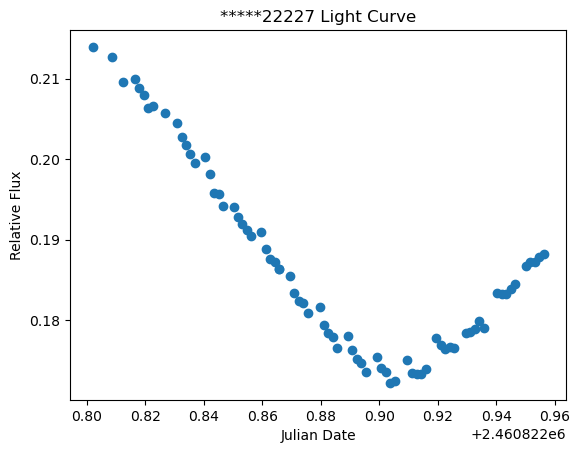

In [10]:
UTC=data_table['JD_UTC']
T1flux=data_table['rel_flux_T1']

plt.plot(UTC, T1flux, 'o')
plt.xlabel('Julian Date')
plt.ylabel('Relative Flux')
plt.title('*****22227 Light Curve')

## Curve fit and lombscargle

Estimated period from Lomb-Scargle: 0.2504 days (6.01 hours)


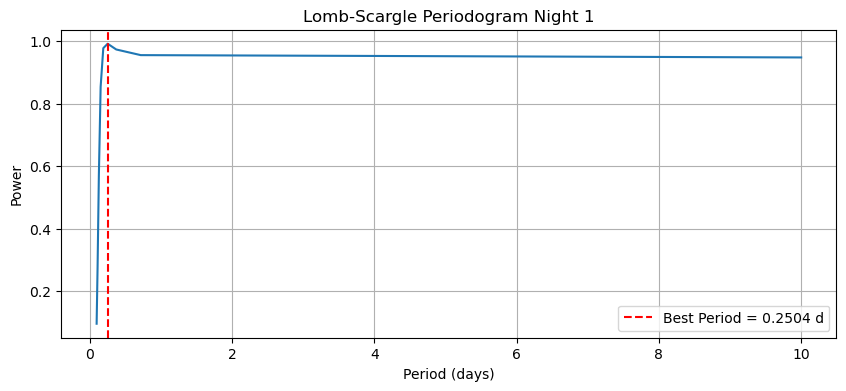

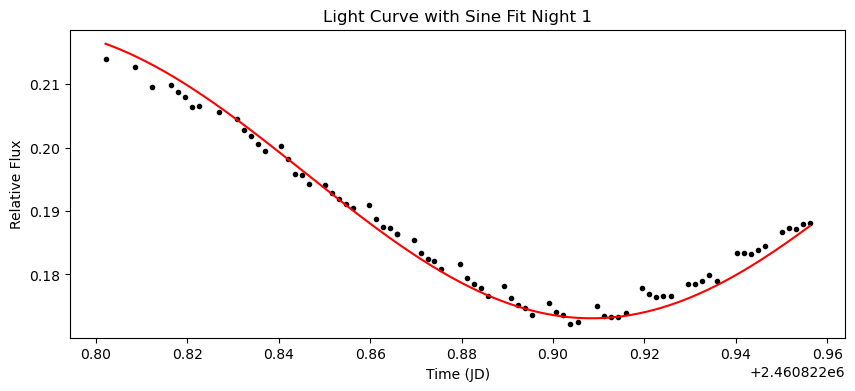

Fitted parameters:
Amplitude = -0.0229
Period = 0.2504 days (6.01 hours)
Phase = -0.1000
Offset = 0.1960


In [29]:
#data
time = data_table['JD_UTC']
flux = data_table['rel_flux_T1']

# Lomb-Scargle
#take a power series and find the frequency
frequency, power = LombScargle(time, flux).autopower(minimum_frequency=0.1, maximum_frequency=10)
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

print(f"Estimated period from Lomb-Scargle: {best_period:.4f} days ({best_period*24:.2f} hours)")

# Plot period
plt.figure(figsize=(10,4))
plt.plot(1/frequency, power)
plt.axvline(best_period, color='red', linestyle='--', label=f'Best Period = {best_period:.4f} d')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram Night 1')
plt.legend()
plt.grid(True)
plt.show()

# fit a sin model with period and other guessed values
def sine_model(t, A, P, phi, offset):
    return A * np.sin(2 * np.pi * t / P + phi) + offset

A_guess = (np.max(flux) - np.min(flux)) / 2
P_guess = best_period
phi_guess = -.1
offset_guess = np.mean(flux)

p0 = [A_guess, P_guess, phi_guess, offset_guess]

#Fit sine model
popt, pcov = curve_fit(sine_model, time, flux, p0=p0)

# Plot data + fit
t_fit = np.linspace(np.min(time), np.max(time), 1000)
flux_fit = sine_model(t_fit, *popt)

plt.figure(figsize=(10,4))
plt.plot(time, flux, 'ko', markersize=3, label='Data')
plt.plot(t_fit, flux_fit, 'r-', label=f'Sin fit (Period={popt[1]:.4f} d)')
plt.xlabel('Time (JD)')
plt.ylabel('Relative Flux')
plt.title('Light Curve with Sine Fit Night 1')
plt.show()

print(f"Fitted parameters:")
print(f"Amplitude = {popt[0]:.4f}")
print(f"Period = {popt[1]:.4f} days ({popt[1]*24:.2f} hours)")
print(f"Phase = {popt[2]:.4f}")
print(f"Offset = {popt[3]:.4f}")


# Emcee

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:36<00:00, 55.35it/s]


Amplitude: 0.0182
Period:    0.2314 days ≈ 5.55 hr
Phase:     -0.0942
Offset:    0.1935


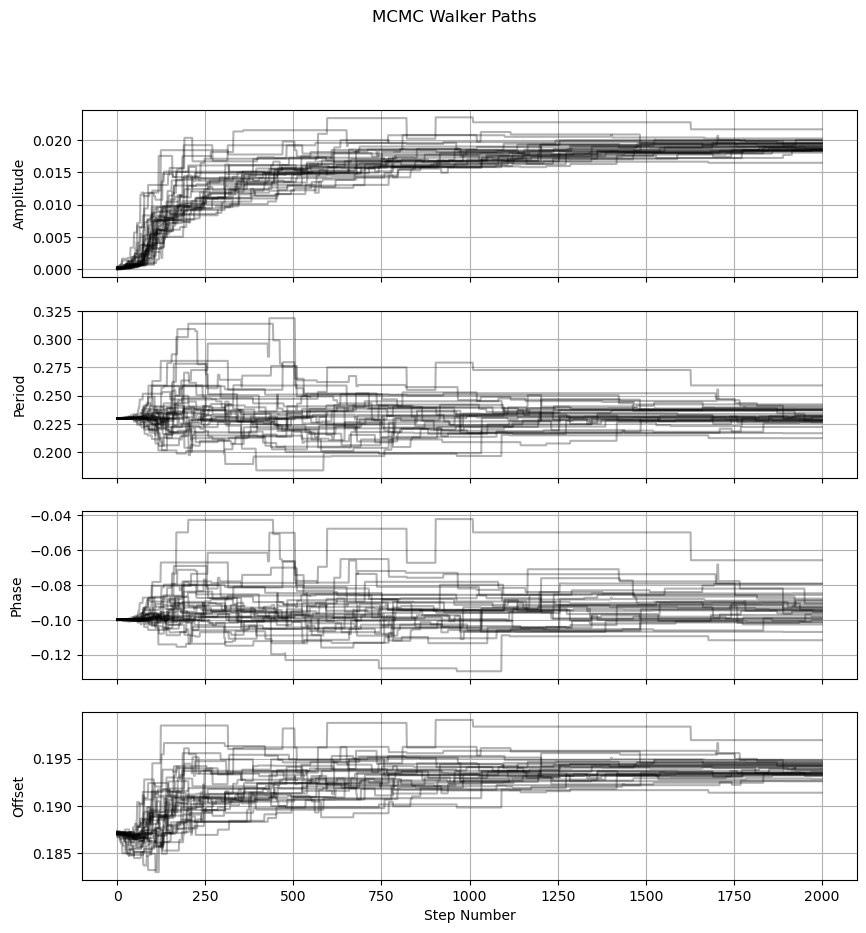

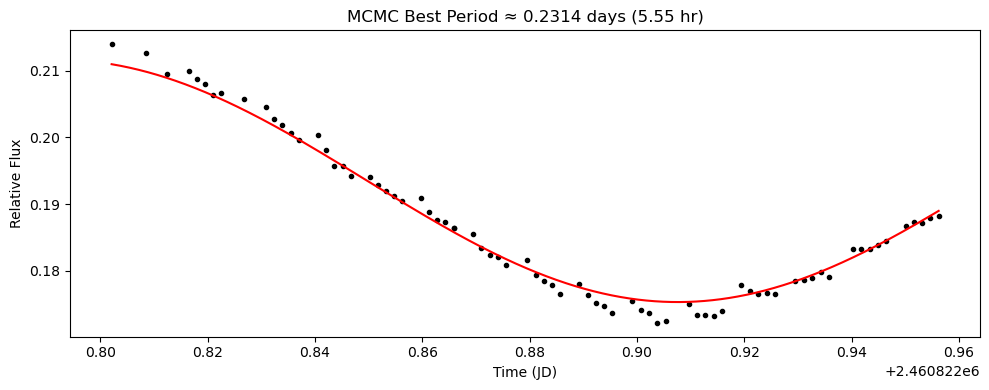

In [30]:
# Data
time = data_table['JD_UTC']
flux = data_table['rel_flux_T1']
flux_err = data_table['rel_flux_err_T1']

# Sin Model
def sine_model(t, A, P, phi, offset):
    return A * np.sin(2 * np.pi * t / P + phi) + offset

# Log-likelihood
def log_likelihood(theta, t, y, yerr):
    A, P, phi, offset = theta
    model = sine_model(t, A, P, phi, offset)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

#Log-prior
#Represents the prior knowlege about the data
#
def log_prior(theta):
    A, P, phi, offset = theta
    if 0 < A < 1 and 0.1 < P < 2 and -2*np.pi < phi < 2*np.pi and -2 < offset < 2:
        return 0.0
    return -np.inf

# Full posterior
def log_probability(theta, t, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr)

#  Initial guess using curve_fit 
initial_guess = [.001, .23, -.1, np.mean(flux)]
popt, _ = curve_fit(sine_model, time, flux, p0=initial_guess)


#Run emcee 
ndim, nwalkers = 4, 32
pos = popt + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_err))
sampler.run_mcmc(pos, 2000, progress=True)


#Plot walker paths for each parameter
samples = sampler.get_chain()
labels = ["Amplitude", "Period", "Phase", "Offset"]

fig, axes = plt.subplots(ndim, figsize=(10, 2.5 * ndim), sharex=True)
for i in range(ndim):
    for walker in range(nwalkers):
        axes[i].plot(samples[:, walker, i], color="k", alpha=0.3)
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True)
axes[-1].set_xlabel("Step Number")
fig.suptitle("MCMC Walker Paths ")
plt.show


# Get results
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
best_fit = np.median(flat_samples, axis=0)

#  Plot result
t_fit = np.linspace(min(time), max(time), 1000)
flux_fit = sine_model(t_fit, *best_fit)

plt.figure(figsize=(10, 4))
plt.plot(time, flux, 'ko', markersize=3, label='Data')
plt.plot(t_fit, flux_fit, 'r-', label='MCMC Fit')
plt.xlabel("Time (JD)")
plt.ylabel("Relative Flux")
plt.title(f"MCMC Best Period ≈ {best_fit[1]:.4f} days ({best_fit[1]*24:.2f} hr)")
plt.tight_layout()
plt.show

print(f"Amplitude: {best_fit[0]:.4f}")
print(f"Period:    {best_fit[1]:.4f} days ≈ {best_fit[1]*24:.2f} hr")
print(f"Phase:     {best_fit[2]:.4f}")
print(f"Offset:    {best_fit[3]:.4f}")


100% guessed

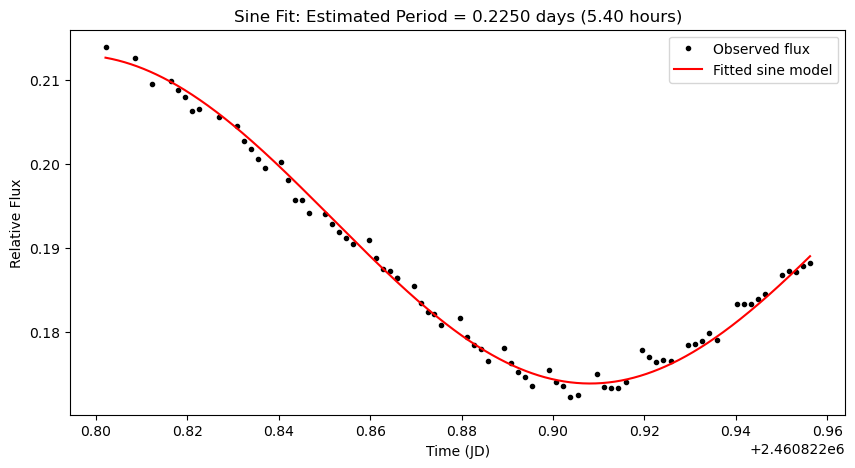

Amplitude: 0.0196
Period: 0.2250 days ≈ 5.40 hours
Phase: -0.1000
Offset: 0.1934


In [31]:

# Step 1: Extract your data
time = data_table['JD_UTC']
flux = data_table['rel_flux_T1']

# Step 2: Define a sinusoidal model
def sine_model(t, A, P, phase, offset):
    return A * np.sin(2 * np.pi * t / P + phase) + offset

# Step 3: Initial parameter guesses
A_guess = (np.max(flux) - np.min(flux)) / 2
P_guess = 0.225  # Try different guesses if you suspect a rough period
phase_guess = -.1
offset_guess = np.mean(flux)

# Step 4: Fit the model to the data
popt, pcov = curve_fit(
    sine_model, time, flux,
    p0=[A_guess, P_guess, phase_guess, offset_guess]
)
A_fit, P_fit, phase_fit, offset_fit = popt

# Step 5: Plot original data and fitted model
t_fit = np.linspace(np.min(time), np.max(time), 1000)
flux_fit = sine_model(t_fit, A_fit, P_fit, phase_fit, offset_fit)

plt.figure(figsize=(10, 5))
plt.plot(time, flux, 'ko', markersize=3, label='Observed flux')
plt.plot(t_fit, flux_fit, 'r-', label='Fitted sine model')
plt.xlabel("Time (JD)")
plt.ylabel("Relative Flux")
plt.title(f"Sine Fit: Estimated Period = {P_fit:.4f} days ({P_fit * 24:.2f} hours)")
plt.legend()
plt.show()

# Print fit values
print(f"Amplitude: {A_fit:.4f}")
print(f"Period: {P_fit:.4f} days ≈ {P_fit * 24:.2f} hours")
print(f"Phase: {phase_fit:.4f}")
print(f"Offset: {offset_fit:.4f}")


# Second Data Set

In [ ]:
bias_list = glob(r"C:\Users\Alaina\OneDrive\Desktop\flats part 2\BIAS*.fits")
dark_list = glob(r"C:\Users\Alaina\OneDrive\Desktop\flats part 2\DARK*.fits")
flat_list = glob(r"C:\Users\Alaina\OneDrive\Desktop\flats part 2\DOMEFLAT*.fits")
science_list = glob(r"C:\Users\Alaina\OneDrive\Desktop\dateHerTWO\*.fits")

output_dir = r"C:\Users\Alaina\OneDrive\Desktop\arcsat second night final"
#"C:\Users\Alaina\OneDrive\Desktop\arcsat second night final"
# === Processing Steps ===
median_bias = create_median_bias(bias_list, "median_Bias.fits")
median_dark = create_median_dark(dark_list, "median_Bias.fits", "Median_Dark.fits")
median_flat = create_median_flat(flat_list, "median_Bias.fits", "Median_Flat.fits", "Median_Dark.fits")

# === Reduce All Science Frames ===
for i, sci_file in enumerate(science_list):
    reduce_science_frame(
        science_filename=sci_file,
        median_bias_filename="median_Bias.fits",
        median_flat_filename="Median_Flat.fits",
        median_dark_filename="Median_Dark.fits",
        output_dir=output_dir
    )


In [27]:

def calculate_gain(files):
    """This function must:

    - Accept a list of files that you need to calculate the gain
      (two files should be enough, but what kind?).
    - Read the files and calculate the gain in e-/ADU.
    - Return the gain in e-/ADU.

    """
  #  file1, file2 = files


    data1 = fits.getdata(flat_list[0]).astype('f4')
    data2 = fits.getdata(flat_list[1]).astype('f4')


    flat_diff = data1 - data2
    flat_diff_var = np.var(flat_diff)

    # Get the signal as the average of the two images
    mean_signal = 0.5 * np.mean(data1 + data2)
    
    # Calculate the gain
    gain = float(2 * mean_signal / flat_diff_var)


    
    return gain


def calculate_readout_noise(files, gain):
    """This function must:

    - Accept a list of files that you need to calculate the readout noise
      (two files should be enough, but what kind?).
    - Accept the gain in e-/ADU as gain. This should be the one you calculated
      in calculate_gain.
    - Read the files and calculate the readout noise in e-.
    - Return the readout noise in e-.

    """
  #  file1, file2 = files


    data1 = fits.getdata(flat_list[0]).astype('f4')
    data2 = fits.getdata(flat_list[1]).astype('f4')



    flat_diff = data1 - data2
    flat_diff_var = np.std(flat_diff)

    # Calculate the readout noise
    readout_noise_adu = np.sqrt(flat_diff_var / 2)
    readout_noise = float(readout_noise_adu * gain)

    
    return readout_noise

flat_list= [r"C:\Users\Alaina\OneDrive\Desktop\flats part 2\domeflat_r_001.fits",
            r"C:\Users\Alaina\OneDrive\Desktop\flats part 2\domeflat_r_002.fits"]
bias_list = [r"C:\Users\Alaina\OneDrive\Desktop\flats part 2\Bias_BIN1_20250606_025113.fits",
            r"C:\Users\Alaina\OneDrive\Desktop\flats part 2\Bias_BIN1_20250606_025125.fits"]
gain = calculate_gain(flat_list)
print(f'Gain is {gain} in e-/ADU')

readout_noise = calculate_readout_noise(bias_list, gain)
print(f'Readout noise is {readout_noise} in e-')

Gain is 1.42484733219251 in e-/ADU
Readout noise is 12.993291103105657 in e-


Text(0.5, 1.0, '*****22227 Light Curve')

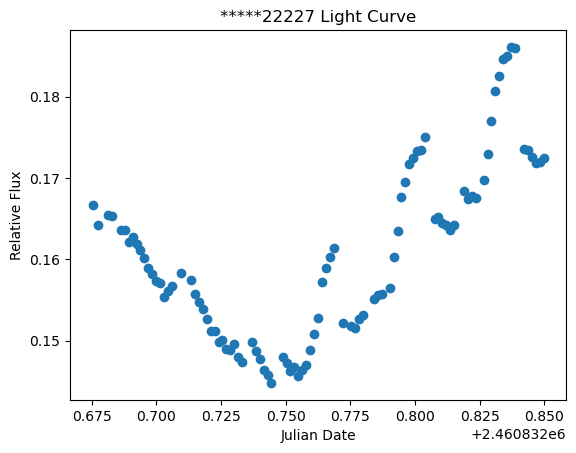

In [35]:
from astropy.table import Table

# Path to your file
file_path1 = r"C:\Users\Alaina\OneDrive\Desktop\nejray.tbl"
# Load the table
data_table1 = Table.read(file_path1, format='ascii')

import matplotlib.pyplot as plt


UTC1=data_table1['JD_UTC']
T1flux1=data_table1['rel_flux_T1']

plt.plot(UTC1, T1flux1, 'o')
plt.xlabel('Julian Date')
plt.ylabel('Relative Flux')
plt.title('*****22227 Light Curve')


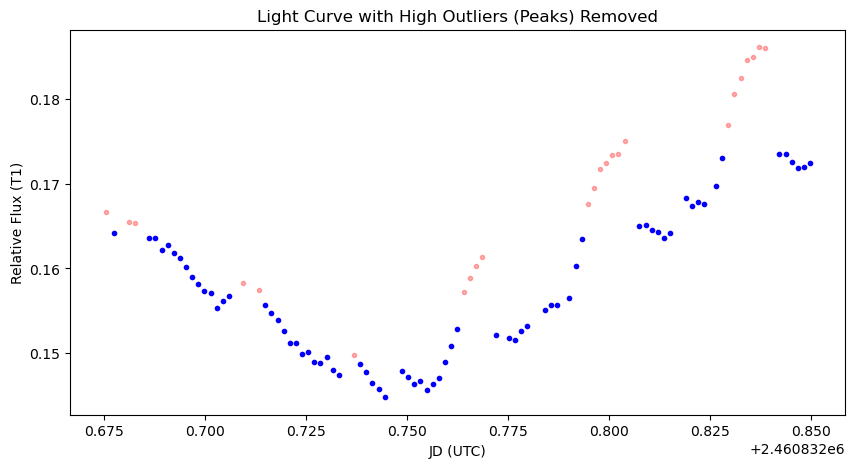

In [44]:

# Convert to numpy arrays
time = np.array(UTC1)
flux = np.array(T1flux1)

# Smooth the light curve using a moving median
window_size = 23  
smoothed_flux = median_filter(flux, size=window_size)

# Mask only points significantly *above* the trend
threshold = .4 * np.std(flux - smoothed_flux)
mask = flux < (smoothed_flux + threshold) 

# Apply mask
time_clean = time[mask]
flux_clean = flux[mask]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time, flux, 'r.', alpha=0.3, label='Original Data')
plt.plot(time_clean, flux_clean, 'b.', label='Peaks Masked')
plt.xlabel('JD (UTC)')
plt.ylabel('Relative Flux (T1)')
plt.title('Light Curve with High Outliers (Peaks) Removed')
plt.show()


Estimated period from Lomb-Scargle: 0.2108 days (5.06 hours)


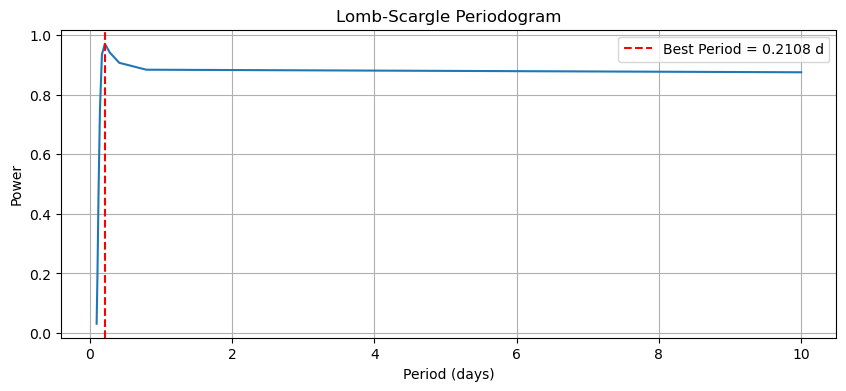

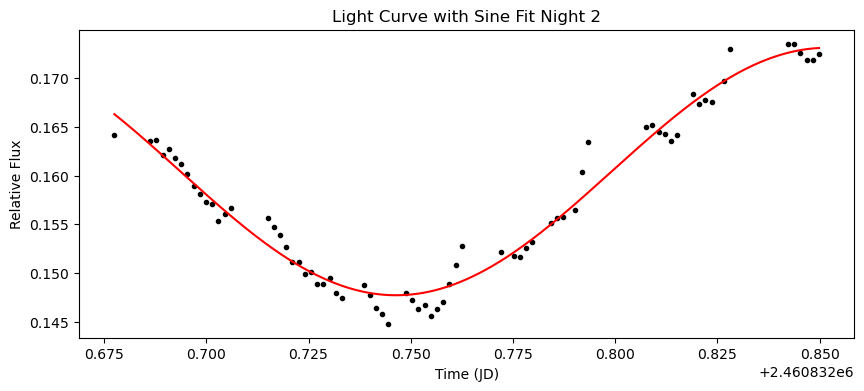

Fitted parameters:
Amplitude = 0.0127
Period = 0.2108 days (5.06 hours)
Phase = -0.1000
Offset = 0.1604


In [50]:

# Data
time = time_clean
flux = flux_clean

# Step 1: Lomb-Scargle periodogram to find best period
frequency, power = LombScargle(time, flux).autopower(minimum_frequency=0.1, maximum_frequency=10)
best_frequency = frequency[np.argmax(power)]
best_period = 1 / best_frequency

print(f"Estimated period from Lomb-Scargle: {best_period:.4f} days ({best_period*24:.2f} hours)")

# Plot periodogram
plt.figure(figsize=(10,4))
plt.plot(1/frequency, power)
plt.axvline(best_period, color='red', linestyle='--', label=f'Best Period = {best_period:.4f} d')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
plt.legend()
plt.grid(True)
plt.show()

# Step 2: Define sine model for fitting
def sine_model(t, A, P, phi, offset):
    return A * np.sin(2 * np.pi * t / P + phi) + offset

# Step 3: Initial guess for curve_fit using Lomb-Scargle period
A_guess = (np.max(flux) - np.min(flux)) / 2
P_guess = best_period
phi_guess = -.1
offset_guess = np.mean(flux)

p0 = [A_guess, P_guess, phi_guess, offset_guess]

# Step 4: Fit sine model
popt, pcov = curve_fit(sine_model, time, flux, p0=p0)

# Step 5: Plot data + fit
t_fit = np.linspace(np.min(time), np.max(time), 1000)
flux_fit = sine_model(t_fit, *popt)

plt.figure(figsize=(10,4))
plt.plot(time, flux, 'ko', markersize=3, label='Data')
plt.plot(t_fit, flux_fit, 'r-', label=f'Sin fit (Period={popt[1]:.4f} d)')
plt.xlabel('Time (JD)')
plt.ylabel('Relative Flux')
plt.title('Light Curve with Sine Fit Night 2')
plt.show()

print(f"Fitted parameters:")
print(f"Amplitude = {popt[0]:.4f}")
print(f"Period = {popt[1]:.4f} days ({popt[1]*24:.2f} hours)")
print(f"Phase = {popt[2]:.4f}")
print(f"Offset = {popt[3]:.4f}")


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 127.93it/s]


Amplitude: 0.0125
Period:    0.2303 days ≈ 5.53 hr
Phase:     -0.0999
Offset:    0.1616


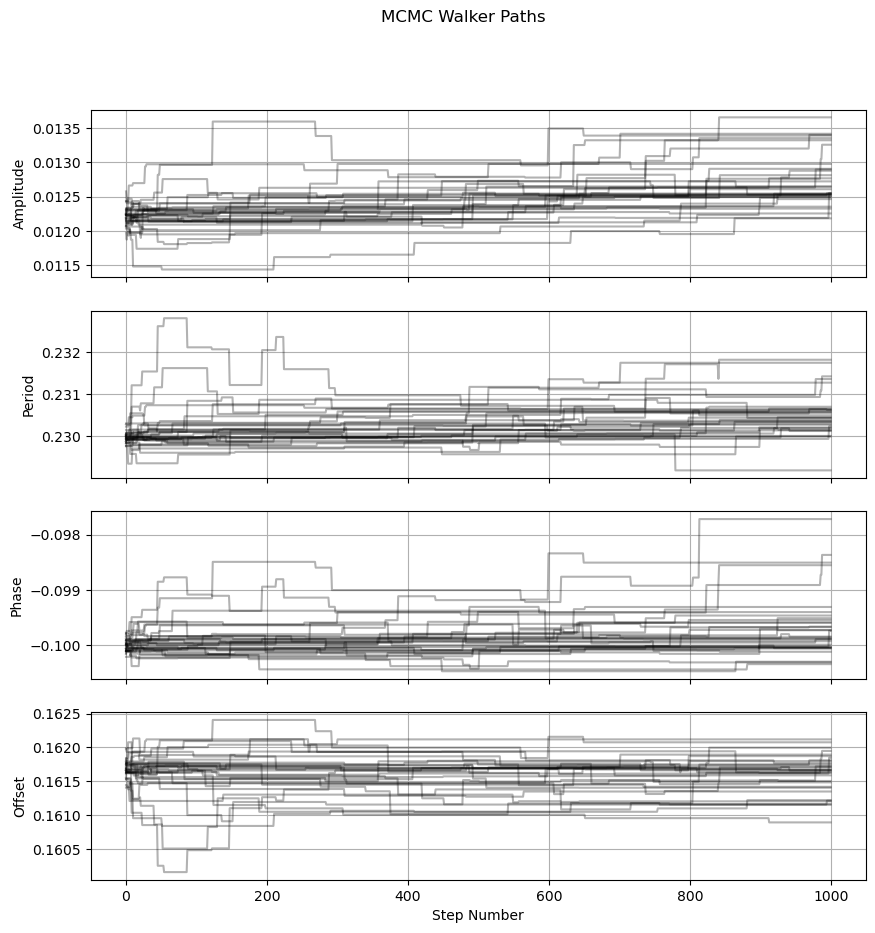

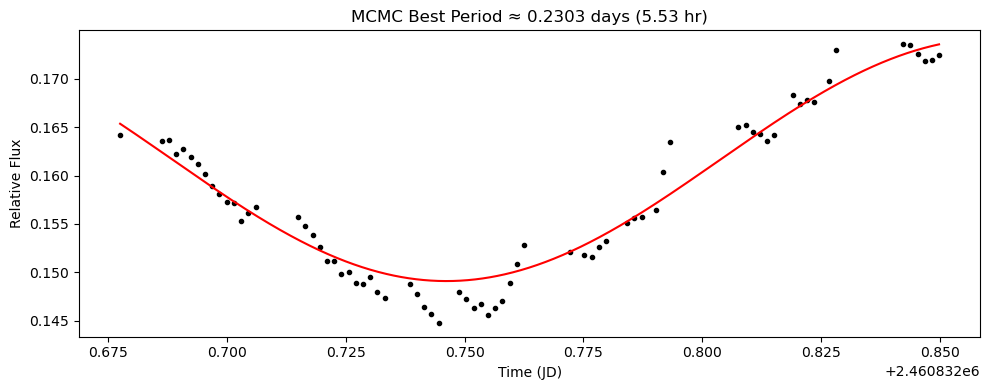

In [47]:

# Data
time = time_clean
flux = flux_clean
flux_err = data_table1['rel_flux_err_T1'][mask]

# Sine Model
def sine_model(t, A, P, phi, offset):
    return A * np.sin(2 * np.pi * t / P + phi) + offset

# Log-likelihood
def log_likelihood(theta, t, y, yerr):
    A, P, phi, offset = theta
    model = sine_model(t, A, P, phi, offset)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

#Log-prior
#Represents the prior knowlege about the data
#
def log_prior(theta):
    A, P, phi, offset = theta
    if 0 < A < 1 and 0.1 < P < 2 and -2*np.pi < phi < 2*np.pi and -2 < offset < 2:
        return 0.0
    return -np.inf

# Full posterior
def log_probability(theta, t, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr)

#  Initial guess using curve_fit 
initial_guess = [.01, .23, -.1, np.mean(flux)]
popt, _ = curve_fit(sine_model, time, flux, p0=initial_guess)


#Run emcee 
ndim, nwalkers = 4, 32
pos = popt + 1e-4 * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(time, flux, flux_err))
sampler.run_mcmc(pos, 1000, progress=True)


#Plot walker paths for each parameter
samples = sampler.get_chain()
labels = ["Amplitude", "Period", "Phase", "Offset"]

fig, axes = plt.subplots(ndim, figsize=(10, 2.5 * ndim), sharex=True)
for i in range(ndim):
    for walker in range(nwalkers):
        axes[i].plot(samples[:, walker, i], color="k", alpha=0.3)
    axes[i].set_ylabel(labels[i])
    axes[i].grid(True)
axes[-1].set_xlabel("Step Number")
fig.suptitle("MCMC Walker Paths ")
plt.show


# Get results
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
best_fit = np.median(flat_samples, axis=0)

#  Plot result
t_fit = np.linspace(min(time), max(time), 1000)
flux_fit = sine_model(t_fit, *best_fit)

plt.figure(figsize=(10, 4))
plt.plot(time, flux, 'ko', markersize=3, label='Data')
plt.plot(t_fit, flux_fit, 'r-', label='MCMC Fit')
plt.xlabel("Time (JD)")
plt.ylabel("Relative Flux")
plt.title(f"MCMC Best Period ≈ {best_fit[1]:.4f} days ({best_fit[1]*24:.2f} hr)")
plt.tight_layout()
plt.show

print(f"Amplitude: {best_fit[0]:.4f}")
print(f"Period:    {best_fit[1]:.4f} days ≈ {best_fit[1]*24:.2f} hr")
print(f"Phase:     {best_fit[2]:.4f}")
print(f"Offset:    {best_fit[3]:.4f}")


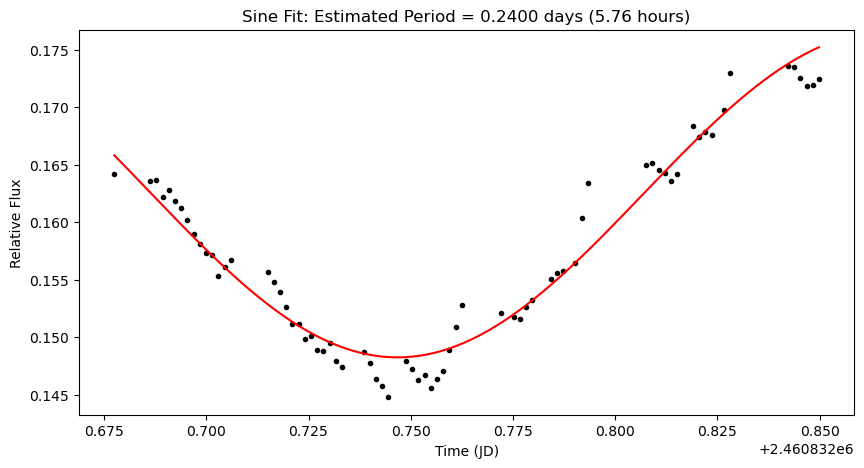

Amplitude: 0.0142
Period: 0.2400 days ≈ 5.76 hours
Phase: -0.1000
Offset: 0.1624


In [49]:

# clean data
time = time_clean
flux = flux_clean

# Define a sinusoidal model
def sine_model(t, A, P, phase, offset):
    return A * np.sin(2 * np.pi * t / P + phase) + offset

#Initial parameter guesses
A_guess = (np.max(flux) - np.min(flux)) / 2
P_guess = 0.24  # Try different guesses if you suspect a rough period
phase_guess = -.1
offset_guess = np.mean(flux)

#Fit the model to the data
popt, pcov = curve_fit(
    sine_model, time, flux,
    p0=[A_guess, P_guess, phase_guess, offset_guess]
)
A_fit, P_fit, phase_fit, offset_fit = popt

#Plot original data and fitted model
t_fit = np.linspace(np.min(time), np.max(time), 1000)
flux_fit = sine_model(t_fit, A_fit, P_fit, phase_fit, offset_fit)

plt.figure(figsize=(10, 5))
plt.plot(time, flux, 'ko', markersize=3, label='Observed flux')
plt.plot(t_fit, flux_fit, 'r-', label='Fitted sine model')
plt.xlabel("Time (JD)")
plt.ylabel("Relative Flux")
plt.title(f"Sine Fit: Estimated Period = {P_fit:.4f} days ({P_fit * 24:.2f} hours)")
plt.show()

# Print fit values
print(f"Amplitude: {A_fit:.4f}")
print(f"Period: {P_fit:.4f} days ≈ {P_fit * 24:.2f} hours")
print(f"Phase: {phase_fit:.4f}")
print(f"Offset: {offset_fit:.4f}")
